In [116]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
import random
from skimage import img_as_ubyte
import os
from skimage.util import random_noise
import matplotlib.pyplot as plt

In [151]:
# dataset

#https://www.kaggle.com/datasets/vencerlanz09/healthy-and-bleached-corals-image-classification

In [117]:
img_size=180
batch_size=16
channels=3

In [118]:
def anticlockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, -angle)

def h_flip(image):
    return  np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(image, (35,35),0)

def gauss_blur_image(image):
    return cv2.GaussianBlur(image, (3,3),2)

def warp_shift(image): 
    transform = AffineTransform(translation=(0,40)) 
    warp_image = warp(image, transform, mode="wrap")
    return warp_image

In [119]:
transformations = {'rotate anticlockwise': anticlockwise_rotation,
                      'rotate clockwise': clockwise_rotation,
                      'horizontal flip': h_flip, 
                      'vertical flip': v_flip,
                   'warp shift': warp_shift,
                   'adding noise': add_noise,
                   'blurring image':blur_image,
                   'gaussian blur':gauss_blur_image
                 }

In [120]:
# images_path=r"E:\\healthy and bleached corals\\healthy_corals"
# augmented_path=r"E:\\healthy and bleached corals\\healthy_corals"
# images_to_generate=300
# images = []

In [121]:
# for im in os.listdir(images_path):     
#     images.append(os.path.join(images_path,im))


In [122]:
# i=1                        

# while i<=images_to_generate:    
#     image=random.choice(images)
#     original_image = io.imread(image)
#     transformed_image=None
# #     print(i)
#     n = 0       
#     transformation_count = random.randint(1, len(transformations)) 
    
#     while n <= transformation_count:
#         key = random.choice(list(transformations)) 
#         transformed_image = transformations[key](original_image)
#         n = n + 1
        
#     new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
#     transformed_image = img_as_ubyte(transformed_image)  
#     transformed_image=cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB) 
#     cv2.imwrite(new_image_path, transformed_image) 
#     i =i+1



In [123]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("E:\healthy and bleached corals",shuffle=True,image_size=(img_size,img_size),batch_size=batch_size)

Found 923 files belonging to 2 classes.


In [124]:
class_names=dataset.class_names
n_classes=len(class_names)
print(class_names)

['bleached_corals', 'healthy_corals']


In [125]:
len(dataset)

58

In [126]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())

(16, 180, 180, 3)
[0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1]


In [127]:
def get_dataset_partition_tf(ds,train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split * ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).take(val_size)    
    
    return train_ds,test_ds,val_ds

In [128]:
train,test,val=get_dataset_partition_tf(dataset)

In [129]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.Resizing(img_size,img_size)
])


In [130]:
data_agumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [131]:
img_shape=(batch_size, img_size, img_size, channels)

model=models.Sequential([
    resize_and_rescale,
    data_agumentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=img_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=img_shape)

In [132]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (16, 180, 180, 3)         0         
                                                                 
 sequential_14 (Sequential)  (16, 180, 180, 3)         0         
                                                                 
 conv2d_29 (Conv2D)          (16, 178, 178, 32)        896       
                                                                 
 max_pooling2d_29 (MaxPooli  (16, 89, 89, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (16, 87, 87, 64)          18496     
                                                                 
 max_pooling2d_30 (MaxPooli  (16, 43, 43, 64)          0         
 ng2D)                                               

In [133]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [134]:
history= model.fit(train, epochs=25, batch_size=batch_size, verbose=1, validation_data=val)

Epoch 1/25
46/46 [==============================] - 12s 224ms/step - loss: 0.6664 - accuracy: 0.6252 - val_loss: 0.7078 - val_accuracy: 0.5625
Epoch 2/25
46/46 [==============================] - 10s 221ms/step - loss: 0.6202 - accuracy: 0.6854 - val_loss: 0.5969 - val_accuracy: 0.6800
Epoch 3/25
46/46 [==============================] - 11s 235ms/step - loss: 0.5801 - accuracy: 0.7018 - val_loss: 0.5606 - val_accuracy: 0.6750
Epoch 4/25
46/46 [==============================] - 12s 252ms/step - loss: 0.5825 - accuracy: 0.7018 - val_loss: 0.6015 - val_accuracy: 0.6625
Epoch 5/25
46/46 [==============================] - 12s 250ms/step - loss: 0.5778 - accuracy: 0.6977 - val_loss: 0.5303 - val_accuracy: 0.7333
Epoch 6/25
46/46 [==============================] - 13s 275ms/step - loss: 0.5313 - accuracy: 0.7387 - val_loss: 0.6335 - val_accuracy: 0.7000
Epoch 7/25
46/46 [==============================] - 13s 272ms/step - loss: 0.5521 - accuracy: 0.7147 - val_loss: 0.5095 - val_accuracy: 0.7750

In [141]:
scores=model.evaluate(test)

5/5 [==============================] - 1s 53ms/step - loss: 0.4405 - accuracy: 0.8500


In [142]:
scores

[0.440547376871109, 0.8500000238418579]

In [143]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 46}

In [144]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [145]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

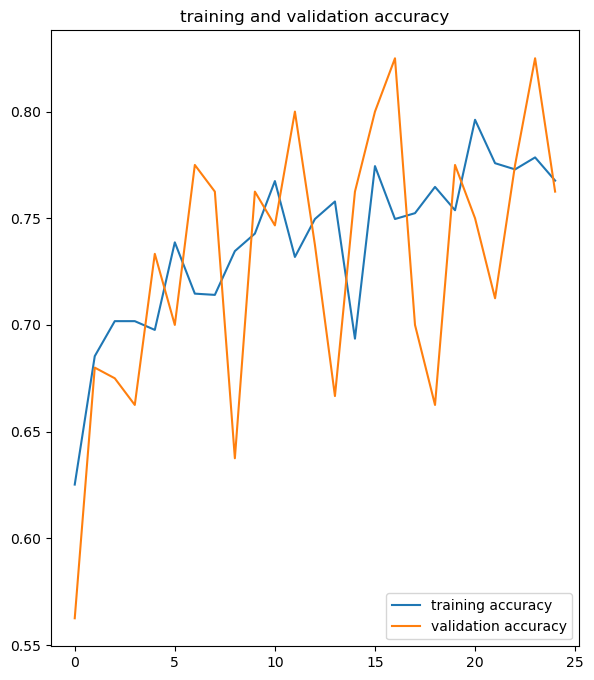

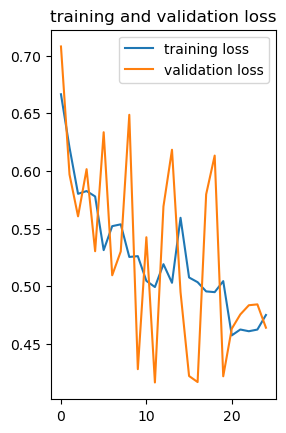

In [148]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(range(25), acc, label='training accuracy')
plt.plot(range(25), val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')
plt.show()

plt.subplot(1,2,2)
plt.plot(range(25), loss, label='training loss')
plt.plot(range(25), val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.title('training and validation loss')
plt.show()

In [149]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])),2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


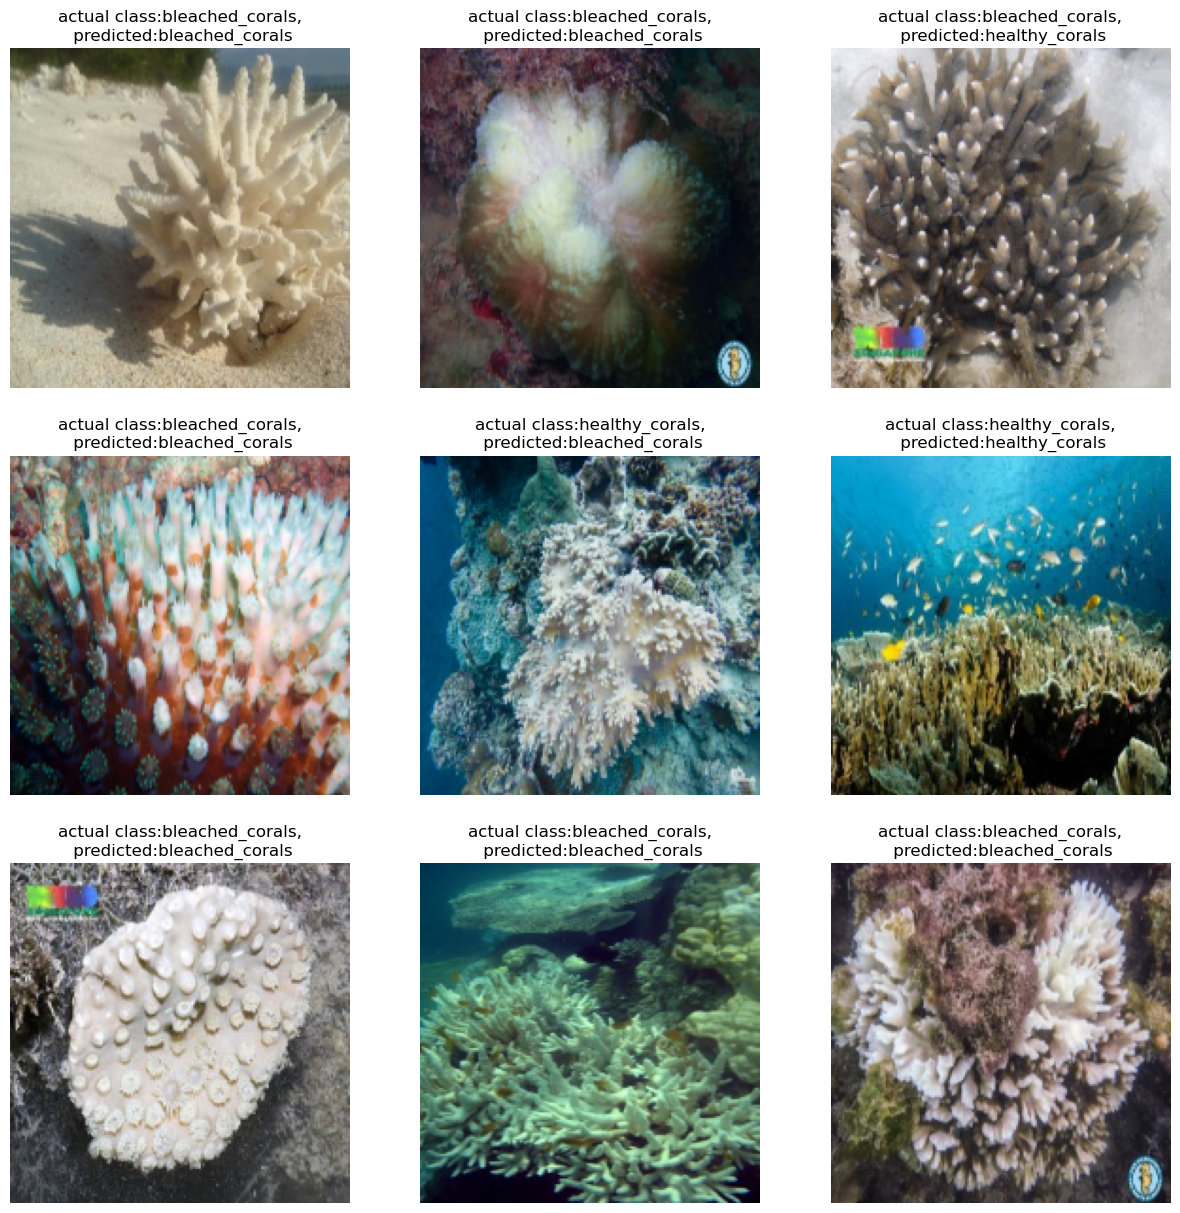

In [150]:
import numpy as np
plt.figure(figsize=(15,15))
for images, labels in test.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"actual class:{actual_class},\n predicted:{predicted_class}")
        
        plt.axis("off")